# Governing Equation
Can be represented in many ways:

### 2nd order ODE

$\ddot{y} = -\frac{k}{mr^2}y - \frac{d}{mr}\dot{y} + \frac{k}{mr}x + \frac{d}{mr}\dot{x}$

### 1st order System

$\begin{bmatrix} \dot{y} \\ \ddot{y} \end{bmatrix} = \begin{bmatrix} 0 & 1 \\ \frac{-k}{mr^2} & \frac{-d}{mr} \end{bmatrix} \begin{bmatrix} y \\ \dot{y} \end{bmatrix} + \begin{bmatrix} 0 & 0 \\ \frac{k}{mr} & \frac{d}{mr} \end{bmatrix} \begin{bmatrix} x \\ \dot{x} \end{bmatrix}$

### Transfer Function

$ \frac{Y(s)}{X(s)} = \frac{k+ds}{mrs^2+ds+k/r} $

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

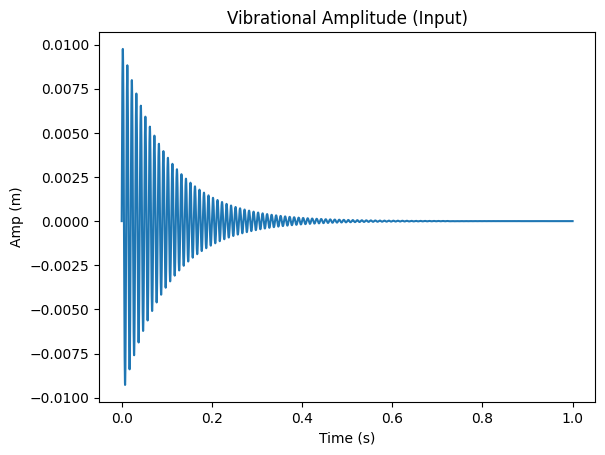

In [11]:
fs = 100000
duration = 1
t = np.linspace(0, duration, duration * fs)
# x = np.hstack((np.zeros(10), np.ones(fs * duration - 10)))
f = 100
tau = 0.1
A = 1e-2
x_in = A * np.sin(2*np.pi*f*t) * np.exp(-t/tau)
plt.plot(t, x_in)
plt.title("Vibrational Amplitude (Input)")
plt.xlabel("Time (s)")
plt.ylabel("Amp (m)")
plt.show()

Max acceleration: 1.62E-02 g


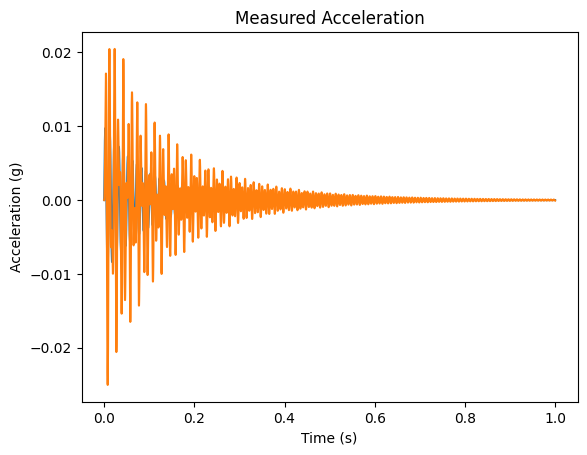

In [19]:
def simulate(x_in, fs, k=1e5, m=0.1, d=1, r=1):
    """
    x_in: Drives the system (m). Vibration input to the system
    fs: Sampling frequency (Hz). Determines the timescale of the drive input
    k: Spring constant (N/m)
    m: Mass of sensor (kg)
    d: Damping factor (Ns/m)
    r: Ratio of cantilever arms. Greater means more motion of the sensor
    """
    t_eval = np.linspace(0, len(x_in) / fs, len(x_in))
    v_in = np.diff(x_in, 1, prepend=[0])
    drive = np.vstack([x_in, v_in]) # x and x_dot in a vector, since the ODE depends on both
    m0 = np.asarray([[0, 1], [-k/m/r**2, -d/m/r]])
    b0 = np.asarray([[0, 0], [k/m/r, d/m/r]])
    # ode = lambda y, y: np.matmul(m0,y) + b0*drive[int(t)]
    def ode(t: float, y: np.ndarray):
        timestep = int(t * fs) - 1
        inp = drive[:, timestep] # [x(t), v(t)]
        return np.matmul(m0, y) + np.matmul(b0, inp)
    ode_result = solve_ivp(ode, t_span=(t_eval[0], t_eval[-1]), y0=[0, 0], t_eval=t_eval)
    success, t, (x, v) = ode_result['success'], ode_result['t'], ode_result['y']
    a = np.diff(v, 1, prepend=[0])
    if not success:
        raise RuntimeError(f"Simulation failed: {ode_result['message']}")
    return t, x, v, a

t, x, v, a = simulate(x_in, fs)

max_accel = np.max(np.abs(a))
max_Gs = max_accel / 9.81
print(f"Max acceleration: {max_Gs:.2E} g")
plt.plot(t, x_in)
plt.plot(t, x)
# axis labels
plt.title("Measured Acceleration")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (g)")
# plt.plot(t, accel)
plt.show()

Max acceleration: 6.34E-02 g


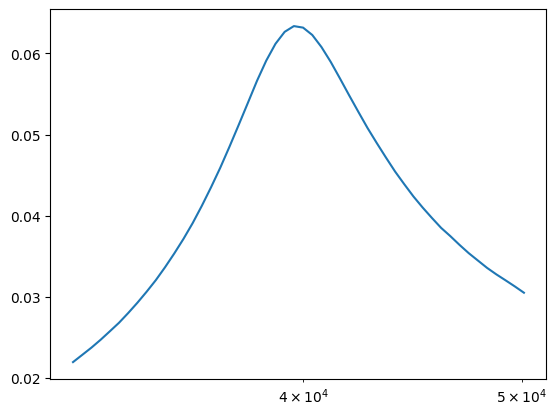

In [13]:
spring_consts = 10**np.linspace(4.5, 4.7, 50)
gs = []

for k in spring_consts:
    t, x, v, a = simulate(x_in, fs, k=k)
    max_accel = np.max(np.abs(a))
    gs.append(max_accel / 9.81)

print(f"Max acceleration: {max(gs):.2E} g")
plt.xscale('log')
plt.plot(spring_consts, gs)
plt.show()

Max acceleration: 1.13E-01 g (at r=1.61E+00)


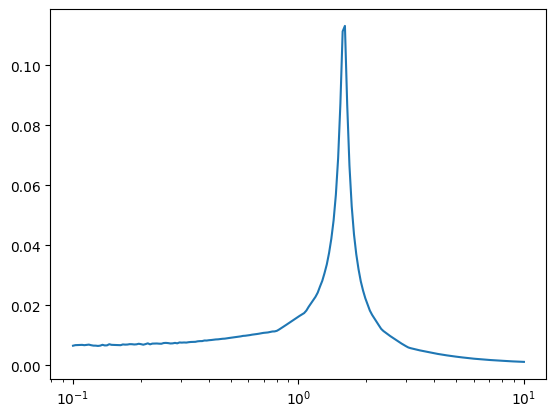

In [23]:
lever_ratios = 10**np.linspace(-1, 1, 200)
gs = []

for r in lever_ratios:
    t, x, v, a = simulate(x_in, fs, r=r)
    max_accel = np.max(np.abs(a))
    gs.append(max_accel / 9.81)

In [ ]:
print(f"Max acceleration: {max(gs):.2E} g (at r={lever_ratios[np.argmax(gs)]:.2f})")
plt.xscale('log')
plt.plot(lever_ratios, gs)
plt.show()